In [2]:
# taken from https://towardsdatascience.com/perceptron-algorithm-in-python-f3ac89d2e537

In [3]:
# imports

from sklearn import datasets
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class Generator:

    def __init__(self):
        self.columns = ['x', 'y', 'labels']

    def makeDF(self, number_of_points):
        return pd.DataFrame(self.makeData(number_of_points), columns=self.columns)
        
    def makeData(self, number_of_points):
        _x, _y = datasets.make_blobs(
            n_samples = number_of_points,
            n_features = 2,
            centers = 2,
            cluster_std = 1.05,
            random_state = 2)
        return list(zip(_x[:,0], _x[:,1], _y))

In [5]:
class Plotter:

    def samples_by_category(self, df):
        return sns.scatterplot(
            x = df.columns[0], 
            y = df.columns[1], 
            data = df,
            hue = df.columns[2])

    def samples_by_category_with_decision_boundary(self, df, theta):
        _feature_1_range = [min(df[:,0]), max(df[:,0])]
        _m = -theta[1]/theta[2]
        _c = -theta[0]/theta[2]
        _feature_2_range = m*_sample_feature_range + c
        _p = self.samples_by_category(df)
        plt.plot(_feature_1_range, _feature_2_range, linewidth=2)


In [6]:
class RandomData: 

    def __init__(self, number_of_points):
        self.df = Generator().makeDF(number_of_points)
        self.plotter = Plotter()

    def plot(self):
        self.plotter.samples_by_category(self.df)

In [7]:
class Perceptron:

    def __init__(self, data):
        self.epochs = 100
        self.learning_rate = 0.1
        self.data = data
        self.labels = self.data.iloc[:,-1]
        self.samples = self.data.iloc[:,:-1]
        self.sample_count = self.samples.shape[0]
        self.feature_count  = self.samples.shape[1]
        self.theta = np.zeros((self.feature_count + 1, 1))
        self.misclassified_counts = [0 for _ in range(self.sample_count)]
        self.activation_function = ActivationFunction(0.0)
        self.plotter = Plotter()

    def train(self):
        for _ in range(self.epochs):
            for _i, _sample_i in enumerate(self.samples):
                self.misclassified_counts[_i] = 0
                neuron(_i, _sample_i)

    def neuron(self, index, sample):
        _prediction = self.predict(sample)
        self.evaluate_prediction(index, sample, _prediction)
    
    def predict(self, sample):
        _processed_sample = np.insert(sample, 0, 1).reshape(-1,1)
        _dot_product = np.dot(_processed_sample.T, _theta)
        _prediction = self.activation_function.check(_dot_product)
        return _prediction
    
    def evaluate_prediction(self, index, sample, prediction):
        if np.squeeze(prediction, self.labels[index]) == 0: return
        self.theta += self.learning_rate*sample*(self.labels(index) - prediction)
        self.misclassified_count[index] += 1

    def plot_boundary(self):
        self.plotter.samples_by_category_with_decision_boundary(self.data, self.theta)

    def print_initialization(self):
        print(f'epochs: {self.epochs}')
        print(f'learning rate: {self.learning_rate}')
        print(f'sample count: {self.sample_count}')
        print(f'feature count: {self.feature_count}\n')
        print(f'samples:\n{self.samples.head()}\n')
        print(f'labels:\n{self.labels.head()}\n')
        print(f'theta:\n{self.theta}\n')


In [8]:
class ActivationFunction:

    def __init__(self, threashold):
        self.threashold = threashold

    def check(self, data):
        return [activate(_x) if _x > self.threashold else deactivate(_x) for _x in data]

    def activate(self, data):
        return 1.0

    def deactivate(self, data):
        return 0.0

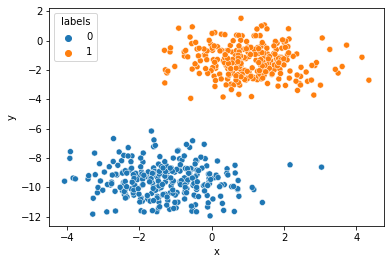

In [9]:
# generate data

_data = RandomData(555)
_data.plot()

In [10]:
# initialize perceptron
_perceptron = Perceptron(_data.df)
_perceptron.epochs = 10

In [11]:
# report on initialized state

_perceptron.print_initialization()

epochs: 10
learning rate: 0.1
sample count: 555
feature count: 2

samples:
          x         y
0  0.804526 -1.717488
1 -0.518481 -9.858924
2  1.296965 -0.873240
3  1.403483 -1.332948
4  0.020311 -0.663226

labels:
0    1
1    0
2    1
3    1
4    1
Name: labels, dtype: int64

theta:
[[0.]
 [0.]
 [0.]]



In [12]:
# train perceptron

_perceptron.train()

NameError: name 'neuron' is not defined

In [ ]:
print(_perceptron.theta)

[[0.]
 [0.]
 [0.]]


In [ ]:
_perceptron.plot_boundary()

InvalidIndexError: (slice(None, None, None), 0)